# Assignment: Transient Groundwater Flow Course IHE feb 2024

By prof. dr.ir. TN Olsthoorn

The [course material](https://github.com/Olsthoorn) can be found on Github

And as an [online course](https://readthedocs.org/profiles/Olsthoorn/) on readthedocs.org

The up-to-date s[yllabus as a pdf](https://github.com/Olsthoorn/TransientGroundwaterFlow) an also be found on Github.

On the same site you can find the PowerPoint presentations that are used in class and numerous exercises done in jupyter notebooks as well as the notebooks that generated the animations and all the pictures in the syllabus.

Old exams with and without answers and the asignments given over the years from 2006 can be find at the end of the [online course](https://readthedocs.org/profiles/Olsthoorn/) on Readthedocs. 

Extra material will be given to the students in class or save on github.

This year there will not be a written exam; only an assigment. This gives more oppertunities to learn and demonstrate the use of the transient analytic solutions presented in the course in a more data science scope. Nowadays, the anlytic formulas are at least as important as in the past before wide-spread computing being available, as more than ever we need them als tools to verify the many numeric models around, which just produce numbers, no insight. There outcomes require verification. Also before starting a new large groundwater model, most and valuable analysis can be and should be done ahead of it, to analyse the problem at hand and it's likely behavior to help us build better models by knowing what matters and by understanding and interpreting its outcomes. Moreover anaytic solutions allow us to generalize other outcomes and allow us to predict which are crucial paramters how variaion of the parameters will affect the outcomes. In short analytic solutions provide insight and guide is all the time when dealing with groundwater problems in a quantitive and qualitative way.

With more data science focus, we talk about analyzing field data using our analytic soltion, to find out how these field data can be interpreted and what the underlying parameters and relations are that cause the observed behavior. This way the filed data, mostly in terms of continuous or high-frequency registrations of water pressures, flows, recharge, evoration, pumping, water level fluctuations and so on, have to be analyzed. Signals have to be separated from noise, further, signals caused by different phenomena, all affecting the registered water pressure, have to be separated to determine what part of the observed behevior is due to what phenomenon, i.e. due to rain, pumping, water fluctuation and so on. These phenomena and their effects are all dynamic, and, therefore, we will mostly deal with large time series, which is what is called data-science.

In [81]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc, k0 as K0, exp1 as Wt
from scipy.integrate import quad
from scipy.signal import lfilter
import pandas as pd
from PIL import Image


In [3]:
def newfig(title='title', xlabel='xlabel', ylabel='ylabel', xscale='linear', yscale='linear',
           xlim=None, ylim=None, figsize=(6, 6)):
    """Return ax of new figure."""
    fig, ax = plt.subplots(1, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    if figsize: fig.set_size_inches = figsize
    ax.grid(True)
    return ax

In [7]:
Wt(0.08)

2.0269410025857417

In [8]:
def Wh(u, rho=0):
    """Return Hantush well function values.

    This function uses numerical integration with scipy.ingegratge.quad
    and vectorizes the obtainded functions to use it with arrays of input.
    
    The resulting function is extremely fast and accurate!

    Parameters
    ----------
    u : float | nd.array of floats
        u = r^2 / (4 kD t)
    rho: float | None
        r / lambda with lambda = sqrt(kD c)

    Some exmple uses
    ----------------
    
    >>>Wh(0.004, 0.03)
    4.894104204671381
    
    >>>Wh(0.08, 0.06)
    2.0184074022446836

    >>>Wh(0.08) # Use Wh without rho, to get the Theis well function value
    2.0269410025857217

    >>>Wt(0.08) # Show that the Theis well funciton Wt(u) = Wh(u)
    2.0269410025857417
    
    """
    def kernel(y, rho):
        """Return the function to be integrated."""
        return np.exp(-y - (rho / 2) ** 2 / y) / y
    def w(u, rho): # Integrate the argument
        return quad(kernel, u, np.inf, args=(rho,))[0]
    wh = np.frompyfunc(w, 2, 1) # Vectorize function w(u, rho) so we can use arrays as input.
    
    return wh(u, rho)



# 1. Show the combined impact of a number of well

A water company extracts water from a dune are along the North sea and uses rows of wells to capture the water. The coordinates in Latitude (North), Longitude (East) are given [here](./data/PumpingSitesLybia.csv).

![Image projected on Google Earth](./images/LybiaPumpingSites.png)


## Let's get the coordinates first:

In [ ]:
psites = pd.read_csv(os.path.join('./data', 'PumpingSitesLybia.csv'), index_col=0)

def wgs2km(phi, lam):
    """Return approximate x [km], y [km] from latitude [deg], longitude [deg]."""
    R = 6378.0 # km
    phi, lam = phi * np.pi / 180., lam * np.pi / 180.
    y = R * phi
    x = R * np.cos(phi) * lam
    return np.round(x, 1), np.round(y, 1)

xkm, ykm = wgs2km(psites['N_GWS84'].values, psites['E_GWS84'].values)

psites['xkm'] = xkm
psites['ykm'] = ykm

xBorderEgypt, yMediterranean = wgs2km(31, 25)
print('The x-coordinate of the Egyption border (Lon = 25deg) = {} km'.format(xBorderEgypt))
print('The y-coordinage of the Mediterranean   (Lat = 31deg) = {} km'.format(yMediterranean))

# Egyptian border point:
xB, yB = wgs2km(25, 25) 
print("Egyptian border point = (x={}, y={})".format(xB, yB))
psites

# The coordinates of the Google image are approximately
# lat 9.5 to 30.0 deg and lon 9.5 to 30 deg
loweleft_upperright_km = wgs2km(np.array([19.8, 33.5]), np.array([9.5, 30.0]))

print(loweleft_upperright_km)

If you know the extent of your image, you can put this image on a figure with the right coordiates and plot your drawdown contours directly on it.

Here is the image put in a pictures with the coordinates in km (y=from equator, x=from zero meridian)

The x-coordinate of the Egyption border (Lon = 25deg) = 2385.4 km
The y-coordinage of the Mediterranean   (Lat = 31deg) = 3450.8 km
Egyptian border point = (x=2522.2, y=2782.9)
(array([ 995. , 2784.8]), array([2204.1, 3729.1]))


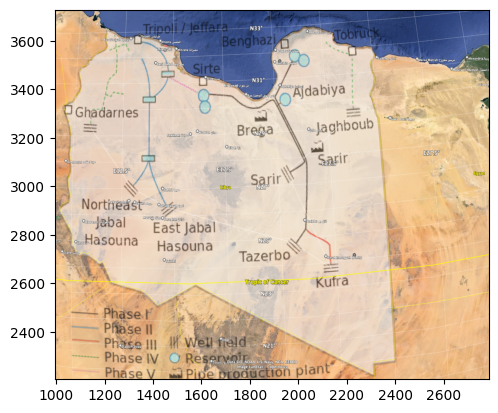

In [ ]:
extent = list(loweleft_upperright_km[0]) + list(loweleft_upperright_km[1])

Lybia_egypt = Image.open('./images/LybiaPumpingSites.png')
plt.imshow(Lybia_egypt, extent=extent)

# Further information:

#### The discharge per pumping site

Now take the pumping capacity given that the transport pipes have $D = 4$ m diameter serving 2 pumping sites. Just assume a flow velocity of $v = 0.5$ m/s on average. The the discharge per pumping sites is estimated to

$$ Q \approx \frac{1}{2} \pi \, D^2 \, v $$

Take this as discharge per pump site.

#### Aquifer properties

Further assume the transmissity of the Nubian Sandstone is $kD = 5000$ m2/d and $S = 0.0005$.

Finally take the Mediterranean sea as a fixed-head boundary, giving rise to mirror wells.

### The questions

1. Start with computing the radius of influence (in km) to have an impression of the extent of the drawdown
1. Compute the drawdown today (assuming that the system has been working since 1984)
1. Contour the drawdown for 2024 directly on the picture.
1. Compute the drawdown over time at the Egypian border at (x=2522.2, y=2782.9)
1. Compute the drawdown over time (1984-2024) at 1000 m from the point Tazerbo assuming this is the approximate radius of the pumping well ensemble.
1. Have a look on Google Earth, zoom in at point (lat=24.2 deg, lon=23.4 deg) to see the well site of Kufra

Remark: The real transmissivity may be less and the real storage coefficient larger than used in this exercise.

## Analyze a pumping experiment that is not exactly according to Theis or to Hantush

During a pumping test in a well the head, and therefore, the drawdown, is measured in a whole series of observation wells. By showing the drawdowns as a function of the logarithm of time since the start of the pumping, a good insight in the reaction of the groundwater due to the pumping. It becomes obvious that the behavior is neither completely according to Theis, nor completely according to Hantush. But we can still analyze it whith the solutions that Theis and Hantush have given us. Analyze the pumping test, given the aquifer (and aquitard) characteristics and explain what is happening here, and therefore, why pumping tests should not be too short, especially what circumstances can make the answer tricky if the pumping test is too short.

# 2. Impact of long-level rise of Lake Nasser (Egypt) on adjacent groundwater

Lake Nasser (Egypt) was formed after construction of the Assuan Dam in the early 20th century. The high dam was ready in 1965, after which Lake Nasser started to rise and extend until what it is today. The rise of the Lake between 1965 and 2005 is shown in the graph. The data with the water level over time is also given.
The rise of the lake level causes infiltration of Lake / Nile water into the aquifers adjacent to the lake. The groundwater in these aquifer will continue to rise over centuries while these aquiers slowly fill up. Full equilibirium will likely never be reached because there are not fixed head boundaries that could cause equilibrium to establish. But then the question raises, how far and to what exent does the groundwater rise? Will low areas get wet and form salt lakes? Can the new groundwater be used for agriculture and when and to what exent, and so on. To answer such questions you are asked to quantify the gradual rise of the grounwater in points at different distances from the lake lying in a cross section.

But to be able to quantify the effect and predict the future of it, you well need to calibrate you parameters kD and S. You can do that by matching your model with observations. Observed heads are available at 6 piezometers situated at different distances from the lake. For each piezometer the head is available for a number of times. You can do the calibration by hand, by changing the kD and the S and run the simulation again until your model matches the data. It is believed from the data obtained from drilling of the piezometers when they were intstalled, that the transmissivity will be in the order of 600 m2/d and the storage coefficient in the order of 5%. So these values are a good starting point for your calibration.

## Questions

#### 1. Show the lake level and the measured heads

Show the lake level and the measured heads as a funciton of time in graphs in a single plot. For this you need to read the data into your notebook and plot them.

#### 2. Construct and test your model

Your model will be the analytic solution that gives the change of head $s(x, t)$ over time caused by a sudden change of head $A$ [m] at $x=0$. That is:
$$ S = A \, \mbox{erfc}(u),\,\,\,\,\,with\,\,\,\,\,u=\sqrt{\frac{x^2 S_y}{4 kD t}} $$

Use `convolution` (i.e. moving average weighted by the response) to simulate the head $h$ at the locations $x$ for which you were given the piezometer data. Show the results in the same plot together with the lake level and the measurements.

Note that the `Step Response` $SR$ is the effect of a sudden change at $x=0$ by $A = 1$ m!
Further realize that the change of head from one day to the next is a sudden change on that day.

The model is imply the convolution (moving average) that ais done by the function `scipy.signal.lfilter(SR, 1, np.diff(hLake))` where `np.diff(hLake)` is an array of the day-to-day changes of the lake level. `np.diff` just computes `hlake[i+1] - hlake[i]` or compactor without neding a loop, `hlake[1:] - hlake[:-1]`.

#### 3. Show that your model works.

In [55]:
name = 'Theo_Olsthoorn'
dirname = os.path.join('./data', name,  'lake_nasser')
assert os.path.isdir(dirname), "Can't find directory {} !".format(dirname)
print(dirname)

./data/Theo_Olsthoorn/lake_nasser


In [57]:
os.listdir(dirname)

['headAt302.csv',
 'headAt3147.csv',
 'nasser_lake.csv',
 'headAt10898.csv',
 'headAt960.csv',
 'headAt27504.csv']

In [60]:
csvfiles = [f for f in os.listdir(dirname) if f.endswith('.csv')]
csvfiles

['headAt302.csv',
 'headAt3147.csv',
 'nasser_lake.csv',
 'headAt10898.csv',
 'headAt960.csv',
 'headAt27504.csv']

In [65]:
lake = pd.read_csv(os.path.join(dirname, 'nasser_lake.csv'), index_col=0)
print(lake.index[:10])

# Convert the dates in the index (which are strings to np.datetime64 objects.
# This can be done most easily with a list comprehension.
# Look up in Google what that is, because comprehensions are extremely powerful
lake.index = [np.datetime64(f) for f in lake.index]
lake.index

Index(['1965-03-12', '1965-03-13', '1965-03-14', '1965-03-15', '1965-03-16',
       '1965-03-17', '1965-03-18', '1965-03-19', '1965-03-20', '1965-03-21'],
      dtype='object', name='Date')


DatetimeIndex(['1965-03-12', '1965-03-13', '1965-03-14', '1965-03-15',
               '1965-03-16', '1965-03-17', '1965-03-18', '1965-03-19',
               '1965-03-20', '1965-03-21',
               ...
               '2004-07-24', '2004-07-25', '2004-07-26', '2004-07-27',
               '2004-07-28', '2004-07-29', '2004-07-30', '2004-07-31',
               '2004-08-01', '2004-08-02'],
              dtype='datetime64[ns]', length=14389, freq=None)

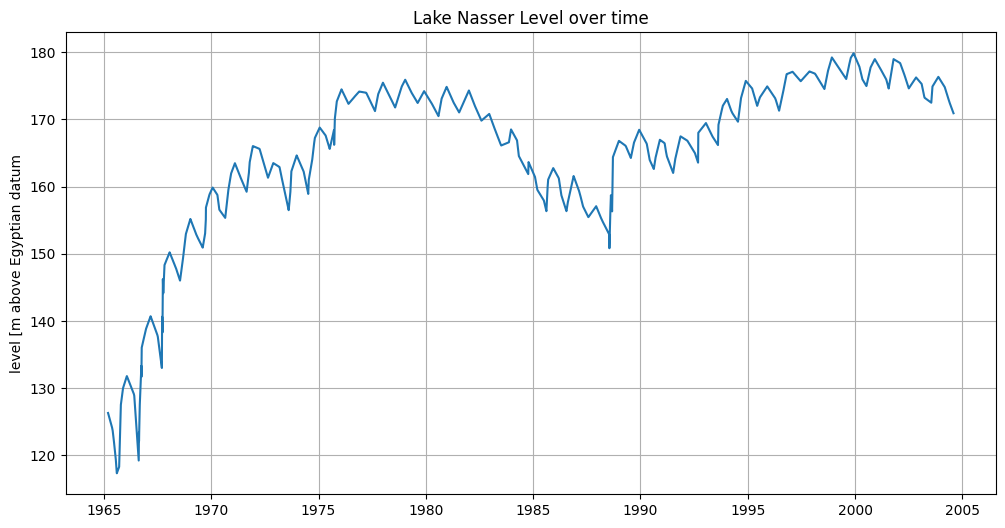

In [70]:
plt.title("Lake Nasser Level over time")
plt.ylabel("level [m above Egyptian datum")
plt.grid()
plt.plot(lake)
# fig = plt.gcf() # gcf() "get current figure" this gives the current figure.
# fig.set_size_inches(12, 6) # the figure has a function to set the size of the figure

In the same way you can add the measurements to the graph. The files with the `.csv holding piezometer data have the same struture as the lake. So they can be read in in exactly the same way.

The index of the pd.Series holding the lake level has np.datetime64 objects. For the modelling we need them converted to floating point numbes. To get these from the index, we can subtact the first value of the index (a datetime) from the whole index, which gives us timedelta64 objects representing the time from the the beginning of the the index (the beginning of the dataset). If we divide these timedelta64 objects by the length of a day, that is np.timedelta64(1 'D'), then we get the desired floating point numbers. Here we go:

In [73]:
tds = lake.index - lake.index[0] # Gives an array of np.timedelta64 objects
tds

TimedeltaIndex([    '0 days',     '1 days',     '2 days',     '3 days',
                    '4 days',     '5 days',     '6 days',     '7 days',
                    '8 days',     '9 days',
                ...
                '14379 days', '14380 days', '14381 days', '14382 days',
                '14383 days', '14384 days', '14385 days', '14386 days',
                '14387 days', '14388 days'],
               dtype='timedelta64[ns]', length=14389, freq=None)

In [75]:
# Divide this tds by the timedelta representing one day, i.e. np.timdelta64(1, 'D') and we have our times in just floating point values
# That we can use in our model.
t / np.timedelta64(1, 'D')

Index([    0.0,     1.0,     2.0,     3.0,     4.0,     5.0,     6.0,     7.0,
           8.0,     9.0,
       ...
       14379.0, 14380.0, 14381.0, 14382.0, 14383.0, 14384.0, 14385.0, 14386.0,
       14387.0, 14388.0],
      dtype='float64', length=14389)

#### 3. Calibrate your model

When the model works, make sure that each run shows the results in a graph immediately. Then after running observe the differences between your model and the measurements.

Adapt the kD and or the S used for the run and run again, until the match between your model and the measurements satisfies you.

Then report the kD and S for which this is the case because these are were the caibration was aiming for.

Show the final results in a graph, together with the lake level.

#### 4. Compute the infiltration from the lake caused by the rise of its level

You are also asked to report on the total volume of water that has infiltrated over time as a consequence of the rise of the lake level.

This can also be computed by convolution. You only need to know the step response and then use the same input. The step response is of course, the infiltration flow caused by a sudeden unit change `A = 1` m at `x = 0`. This flow at x=0 can be easily derived form the formula for the head (using Darcy) but it can also be found in the Syllabus
$$ Q(0, t) = A \sqrt{\frac{kD S}{\pi t}}$$
and, therefore
$$ SR_Q = Q(0, t)\,\,\,\,for\,\,\,\ A=1\,\,\,\, \rightarrow \,\,\,\, SR_Q = \sqrt{\frac{kD S}{\pi t}} $$

#### 5. Compute the total inflow between 1965 and 2005
Once you can simulate this inflow using convolution, you can also integrate it over the total period of your simulation, simply by adding the daily values. So how much it this, and what is its dimension?

This is, of couse, per m of lake coast not for the entire lake which is over 500  km long.

#### 6. Show these inflow over time in a graph below the previous one for comparison.
Is there anything special to remark with respect to the results? If you think so, say so.

#  4. Hantush and Theis type curves

On top of this assignment notebook there is a function defined which computes the Hantush well function $W_h(u, \rho=\frac{r}{\lambda})$. You can use it or the imported function $Wt(u)$ to compute the Theis drawdown. See comment in the function definition for $W_h(u, rho)$ in the top of this notebook).

#### 1. Question

Show the type curves for the Hantush and Theis well functions. A type curve shows the well function on double log scales as a function of 1/u. The Hantush well function does this for different values of $\rho =r / \lambda$.

For the Hantush well function use the following values for `rho=r/lambda`:

In [9]:
rhos = [3, 2, 1, 0.3, 0.2, 0.1, 0.03, 0.02, 0.01]

In [13]:
# Set up the figure using the function Newfig defined near the top of this notebook

#ax = newfig('Hantush type curves', '1/u', 'Wh(u)', xscale='log', yscale='log',
#            ylim=(1e-3, 20), figsize=(8, 8))

# Use the following range for u
u = np.logspace(-6, 1, 71)

for rho in [3, 2, 1, 0.3, 0.2, 0.1, 0.03, 0.02, 0.01]:
    # plot the type curve here using plt.plot(...)
    # document each curve using a label and plut the value of r/L in that label.
    pass
#ax.legend(loc='lower right')

# 5. Pumping experiment

There was a puping test in an aquifer covered by a shallow clay layer on top of which is a sand layer with a very low transmissivt. This sand layer has a water level that is only affected by rain, evaporation and leakage. Ignore the rain and precipitation.

The pumping was done in below the clay layer. The drawdown in both the top and bottom layer was measured in six piezometrs during the entire long pumping test. These drawdowns for each distance to the well are in the accompanying directory in a set of `piez###m.csv` files. Each one has the time of measurement, and the drawdown in the top and bottom layer (aquif1 and aquif2).

In the same directory is a file `Q.txt` which says what the discharge of the well was.

You can read the data in the file using pandas like so:

In [17]:
name = 'Theo_Olsthoorn'
ptest_dir = os.path.join('./data', name, 'pump_test')
assert os.path.isdir(ptest_dir), "Can't open your pump_test directory!"

print(ptest_dir)

./data/Theo_Olsthoorn/pump_test


So the directory exists and it is printed above.
Then look wat files are in it.
I use an external command to show them (by usin the exclamaton point)

In [18]:
!ls './data/Theo_Olsthoorn/pump_test'

Q.txt        piez11m.csv  piez26m.csv  piez85m.csv
piez108m.csv piez22m.csv  piez56m.csv


But we can also use the os module without resorting to an extermal command, yields a list that we can use afterwards.

In [46]:
myfiles = os.listdir(ptest_dir)
print('myfiles =', myfiles)
csvfiles = [f for f in myfiles if f.endswith('.csv')]
print('csvfiles =', csvfiles)

myfiles = ['piez57m.csv', 'piez20m.csv', 'piez70m.csv', 'piez88m.csv', 'piez32m.csv', 'piez12m.csv']
csvfiles = ['piez57m.csv', 'piez20m.csv', 'piez70m.csv', 'piez88m.csv', 'piez32m.csv', 'piez12m.csv']


The Q.txt file has the extraction by the well in [m3/d].

Each csv files has the distance to the well in its name.

We can read them in by pd.read_csv, which yields a pd.DataFrame (a table object with a large number of function (methods) in it.

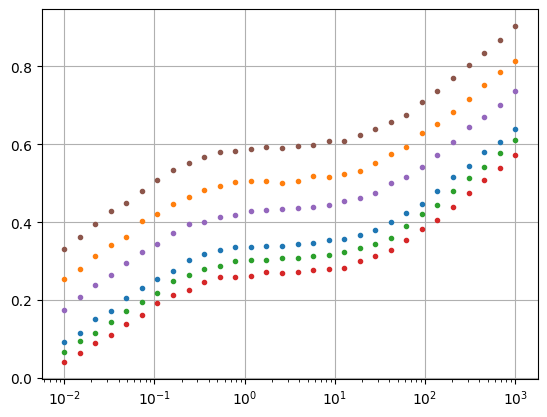

In [52]:
plt.grid()
plt.xscale('log')
for csvfile in csvfiles:
    r = float(csvfile[4:-5])
    pz = pd.read_csv(os.path.join(ptest_dir, csvfile))
    plt.plot(pz['time_d'].values, pz['aquif2'].values, '.', label='pz ({}), r={} m'.format(csvfile, r))

You see the beginnig the measurments follow straight lines as is expected with drawdowns according to Theis. Then they become horizontal, i.e. steady state, according to Hantush. And finally the turn upwards again like (antother Theis).

## Quesions:

#### 1.  Interprete the first part of the measurement lines to determine the transmissivity and the storage coefficient.

With the obtaind kD and S, compute the darwdown according to Theis and plot them with thin lines. Use linewidth (lw=0.5 or so) in the plt.plot command.

#### 2.  Try also to match the curve including the horizontal part using the Hantsh well function

This should give the `lambda` and from it the and the resistance `c`.

You can now add the Hantush drawdown to the plot. They should coincide with the Theis ones in the fist part.

#### 3. Try to match the the straigt part of the lines at the end according to Theis (kD and c)

What is the difference beween the data obtained from the second straight part and the fist straight part of the lines?

With the obtained values of kD and S, add the Theis drawdown curve to the figure..

#### 4. Explain what happens in this case, what causes this curves straight-up - horizontal - straight-up?

#### 5. Add the drawdowns of the top layer to the curves

Finally add the measured drawdowns of the first layer to the plot.

#### 5. Try to explain why they behave like they do.